# Calculate bore speed (celerity)

#### Using the method from Scotti, 2004, with `pymc` UQ

Steps:
1. Load echo and convert to SSC
2. Identify front and plot
3. Calculate beam distances and cross-correlations
4. Minimise estimate error using pymc and plot
5. Save trace and print result

In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cmocean as cm
# from wootils.plotnice import saveclose
import arviz as az
import xarray as xr
from scipy.signal import detrend
from wootils.plotnice import vert_stack
import natsort

import sys
sys.path.insert(0, '../')
from chp3_polarfuncs import SSCArray, get_beam_distances
from chp3_plotfuncs import plot_polar_dirs, plot_beam_distance, add_ellipse
from chp3_pymc3funcs import gen_pymc3_model

sns.set()
sns.set_style("white")
sns.set_style("ticks")

In [2]:
save_dir = r'/mnt/c/Users/00099894/Large_Data/RS2019'
save_dir = os.path.join(save_dir, 'NLIW')

nc_dir = r'/mnt/c/Users/00099894/Large_Data/'
work_dir = r'/mnt/c/Users/00099894/OneDrive - The University of Western Australia/UWA/PhD/pl'

fig_dir = os.path.join('figures', 'nliw_adcp')
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

In [3]:
fieldtrip = 'RS2019'
moor = 'T150'
yr = 2019
temp_file = 'RowleyShoals_Gridded_Mooring_T_SBE56.nc'

## Load the data for event

In [18]:
def get_maxvar_bins(echo, hslice=(35,105), nbins=3):
    """
    Get the bins with the maximum variance
    """
    # get the depth slice
    echo_var = echo.sel(height=slice(*hslice)).var(dim='time').mean(dim='beam').rolling(height=nbins, center=True, min_periods=nbins).mean()
    # get the bin index with the maximum variance
    varmax_ix = np.where(echo.height == echo_var.height[echo_var.argmax()])[0][0]
    # return the height around the peak
    hx = np.arange(varmax_ix-(nbins-1)/2, varmax_ix+(nbins+1)/2)
    plhx = int(np.mean(np.arange(len(hx))))
    return hx, plhx

def get_lagcorr(echo_all, lag_window, hslice=(35,105), nbins=3, theta=20, beampos=[180,0,90,270]):
    """
    Get the lag correlation of the echo intensity
    """
    # Get the peak variance bins
    hx, plhx = get_maxvar_bins(echo_all, hslice=hslice, nbins=nbins)
    hx = hx.astype(int)
    xb, yb, zb, phi = get_beam_distances(echo_all.height[hx].values, theta=20, beampos=[180,0,90,270])
    lag_all, corr_all = echo_all.sscda.beam_xcorr(hx, lag_window)
    return lag_all, corr_all, xb, yb, zb, phi, plhx, hx

In [22]:
# echo_all = xr.DataArray(data=detrend(echo_all, axis=0),
#                         coords={'time': echo_all.time, 'height': echo_all.height, 'beam': echo_all.beam},
#                         dims=['time', 'height', 'beam'])

[21 22 23]
No lags - trying elsewhere
[15 16 17 18 19]
[[[ 0.  1.  0.  0.]
  [-1.  0.  0.  0.]
  [ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]]

 [[ 0.  2.  2.  1.]
  [-2.  0.  0. -1.]
  [-2.  0.  0.  0.]
  [-1.  1.  0.  0.]]

 [[ 0.  2.  1.  1.]
  [-2.  0. -1. -1.]
  [-1.  1.  0.  0.]
  [-1.  1.  0.  0.]]

 [[ 0.  1.  0.  1.]
  [-1.  0.  0.  0.]
  [ 0.  0.  0.  0.]
  [-1.  0.  0.  0.]]

 [[ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]]]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, theta, c]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 4 seconds.


Event 0 saved successfully
[18 19 20]
[[[ 0. -1.  0.  0.]
  [ 1.  0.  0.  1.]
  [ 0.  0.  0.  0.]
  [ 0. -1.  0.  0.]]

 [[ 0. -1.  0.  0.]
  [ 1.  0.  0.  0.]
  [ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]]

 [[ 0. -1. -1. -1.]
  [ 1.  0.  0.  1.]
  [ 1.  0.  0.  0.]
  [ 1. -1.  0.  0.]]]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, theta, c]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 4 seconds.


Event 1 saved successfully
[47 48 49]
[[[ 0. -3. -2. -2.]
  [ 3.  0.  1. -1.]
  [ 2. -1.  0.  0.]
  [ 2.  1.  0.  0.]]

 [[ 0. -4. -2. -2.]
  [ 4.  0.  1.  2.]
  [ 2. -1.  0.  0.]
  [ 2. -2.  0.  0.]]

 [[ 0. -4. -2. -3.]
  [ 4.  0.  1.  1.]
  [ 2. -1.  0.  0.]
  [ 3. -1.  0.  0.]]]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, theta, c]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 3 seconds.


Event 2 saved successfully
[29 30 31]
[[[ 0. -2. -1.  0.]
  [ 2.  0.  0.  0.]
  [ 1.  0.  0. -1.]
  [ 0.  0.  1.  0.]]

 [[ 0. -4. -1. -1.]
  [ 4.  0.  2.  1.]
  [ 1. -2.  0.  0.]
  [ 1. -1.  0.  0.]]

 [[ 0. -6. -1. -1.]
  [ 6.  0.  0.  1.]
  [ 1.  0.  0.  0.]
  [ 1. -1.  0.  0.]]]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, theta, c]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 4 seconds.


Event 3 saved successfully
[47 48 49]
[[[ 0. -3. -2.  0.]
  [ 3.  0.  0.  2.]
  [ 2.  0.  0.  1.]
  [ 0. -2. -1.  0.]]

 [[ 0. -3. -2. -1.]
  [ 3.  0.  0.  2.]
  [ 2.  0.  0.  1.]
  [ 1. -2. -1.  0.]]

 [[ 0. -3. -2. -1.]
  [ 3.  0. -2.  1.]
  [ 2.  2.  0.  2.]
  [ 1. -1. -2.  0.]]]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, theta, c]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 3 seconds.


Event 4 saved successfully
[41 42 43]
[[[ 0. -2. -1. -1.]
  [ 2.  0.  2.  2.]
  [ 1. -2.  0.  0.]
  [ 1. -2.  0.  0.]]

 [[ 0. -1.  0.  0.]
  [ 1.  0.  1.  2.]
  [ 0. -1.  0.  0.]
  [ 0. -2.  0.  0.]]

 [[ 0.  0. -1.  0.]
  [ 0.  0.  0.  0.]
  [ 1.  0.  0.  0.]
  [ 0.  0.  0.  0.]]]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, theta, c]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 4 seconds.


Event 5 saved successfully
[44 45 46]
[[[ 0. -1. -1. -1.]
  [ 1.  0.  0.  0.]
  [ 1.  0.  0.  0.]
  [ 1.  0.  0.  0.]]

 [[ 0. -1. -1. -1.]
  [ 1.  0.  0.  0.]
  [ 1.  0.  0.  0.]
  [ 1.  0.  0.  0.]]

 [[ 0. -1.  0. -1.]
  [ 1.  0.  0.  0.]
  [ 0.  0.  0.  0.]
  [ 1.  0.  0.  0.]]]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, theta, c]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 3 seconds.


Event 6 saved successfully
[42 43 44]
[[[ 0. -3. -2. -1.]
  [ 3.  0.  1.  2.]
  [ 2. -1.  0.  0.]
  [ 1. -2.  0.  0.]]

 [[ 0. -2. -1.  0.]
  [ 2.  0.  1.  2.]
  [ 1. -1.  0.  0.]
  [ 0. -2.  0.  0.]]

 [[ 0. -1. -1.  0.]
  [ 1.  0.  0.  0.]
  [ 1.  0.  0.  0.]
  [ 0.  0.  0.  0.]]]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, theta, c]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 3 seconds.


Event 7 saved successfully
[21 22 23]
[[[ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]]

 [[ 0. -1.  0.  0.]
  [ 1.  0.  0.  0.]
  [ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]]

 [[ 0. -1.  0.  0.]
  [ 1.  0.  0.  1.]
  [ 0.  0.  0.  0.]
  [ 0. -1.  0.  0.]]]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, theta, c]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 4 seconds.
The acceptance probability does not match the target. It is 0.6491659281115965, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.5728001011424508, but should be close to 0.8. Try to increase the number of tuning steps.


Event 8 saved successfully
[21 22 23]
[[[ 0.  1. -1.  0.]
  [-1.  0. -1.  1.]
  [ 1.  1.  0.  1.]
  [ 0. -1. -1.  0.]]

 [[ 0. -1. -1.  0.]
  [ 1.  0.  0.  1.]
  [ 1.  0.  0.  0.]
  [ 0. -1.  0.  0.]]

 [[ 0. -2.  0.  0.]
  [ 2.  0.  1.  0.]
  [ 0. -1.  0.  0.]
  [ 0.  0.  0.  0.]]]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, theta, c]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 4 seconds.


Event 9 saved successfully
[32 33 34]
[[[ 0. -5. -2. -3.]
  [ 5.  0.  2.  0.]
  [ 2. -2.  0.  0.]
  [ 3.  0.  0.  0.]]

 [[ 0. -5. -2. -3.]
  [ 5.  0.  1.  2.]
  [ 2. -1.  0.  0.]
  [ 3. -2.  0.  0.]]

 [[ 0. -6. -1. -1.]
  [ 6.  0.  1.  1.]
  [ 1. -1.  0.  0.]
  [ 1. -1.  0.  0.]]]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, theta, c]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 4 seconds.


Event 10 saved successfully


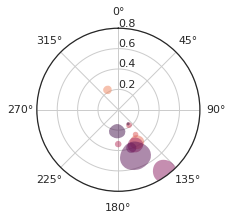

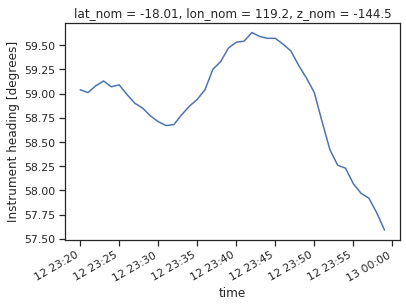

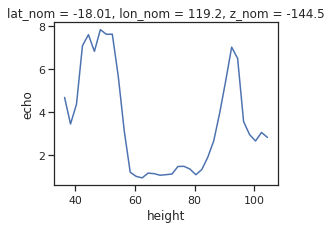

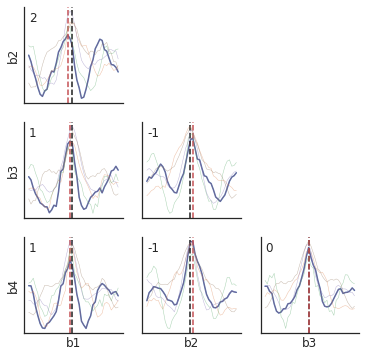

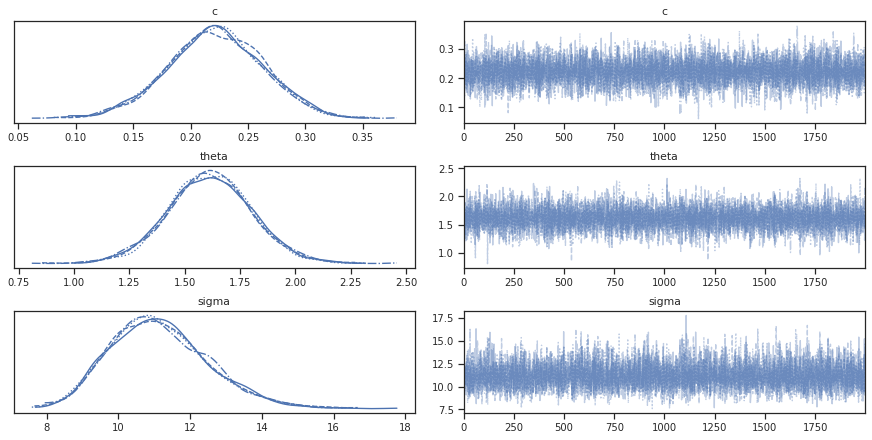

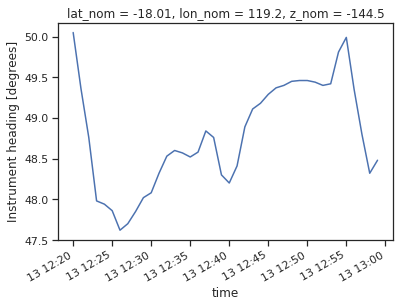

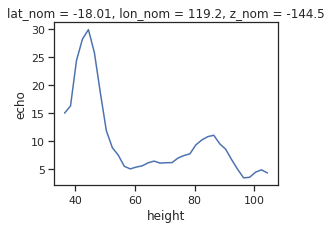

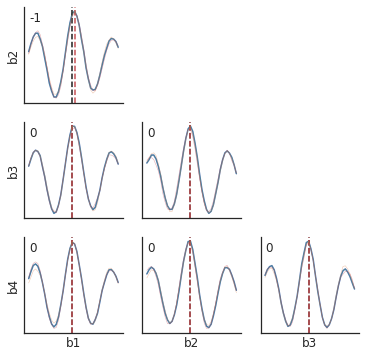

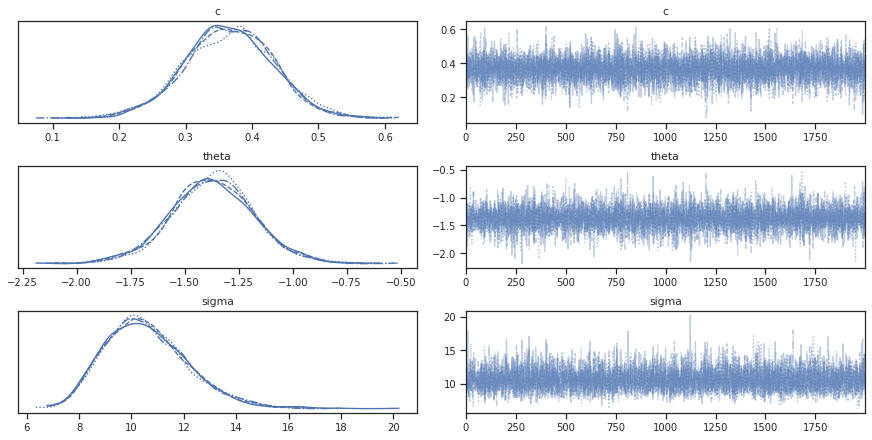

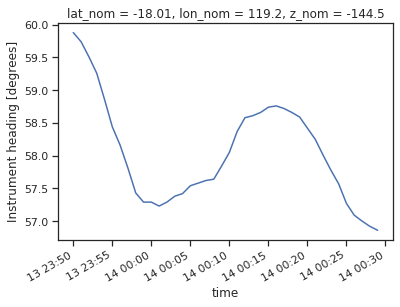

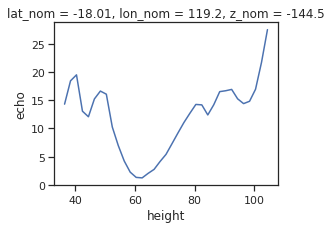

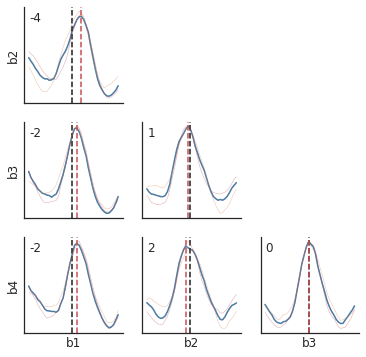

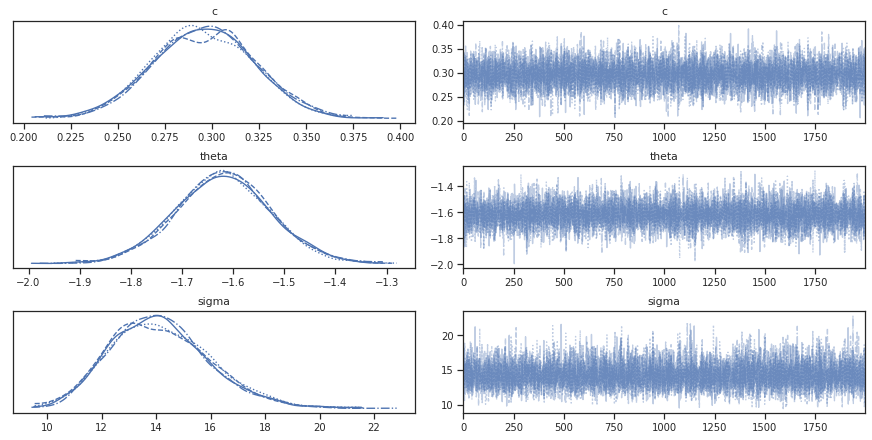

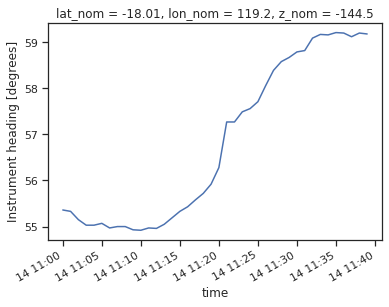

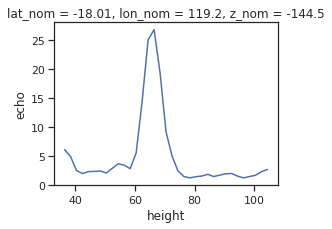

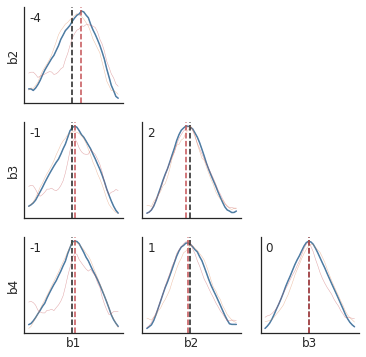

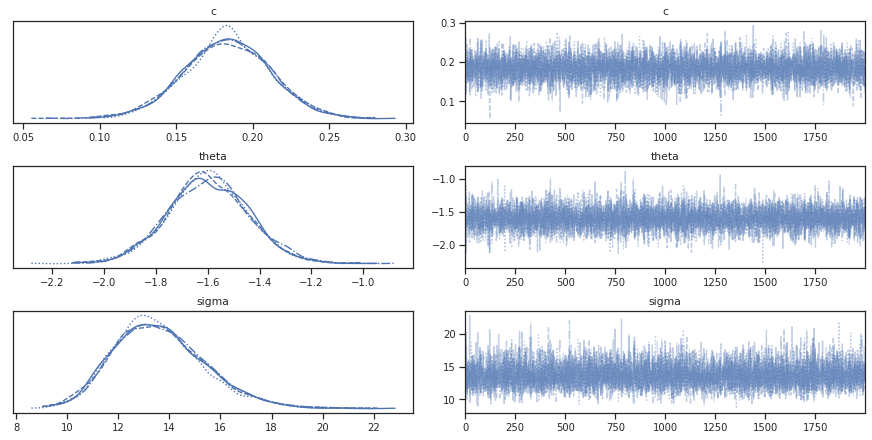

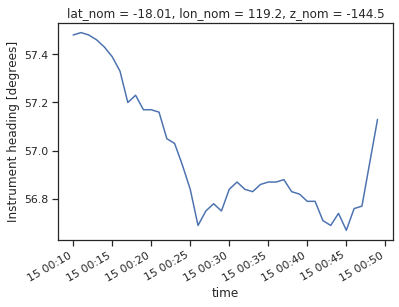

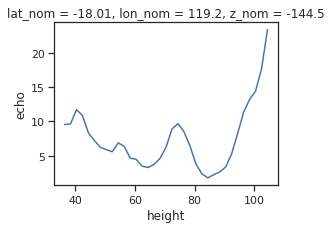

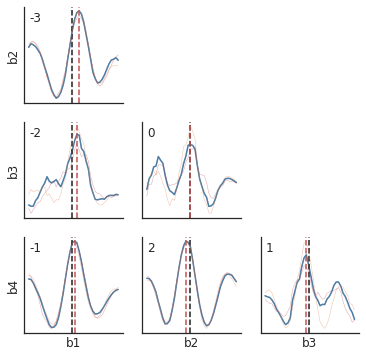

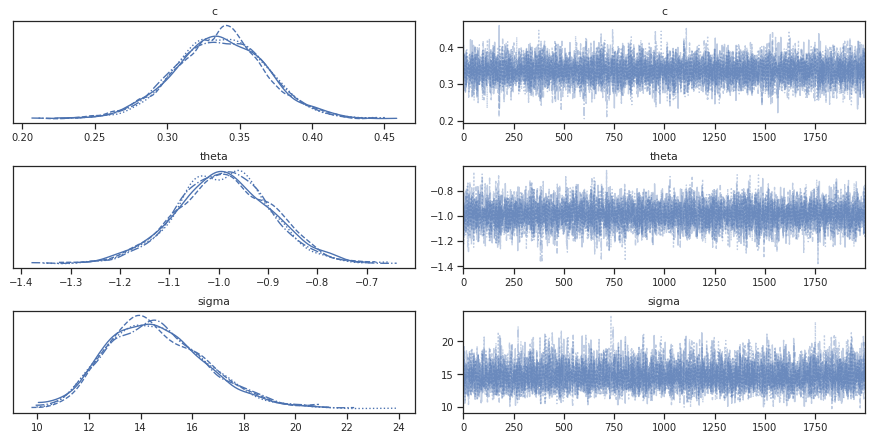

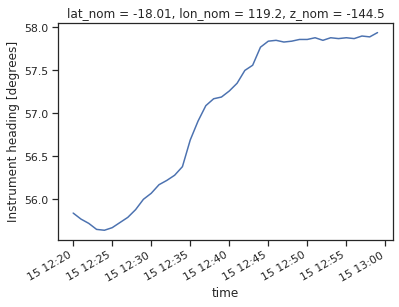

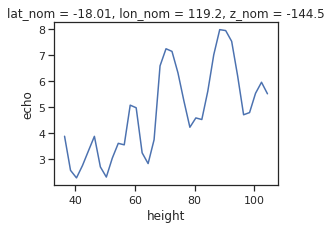

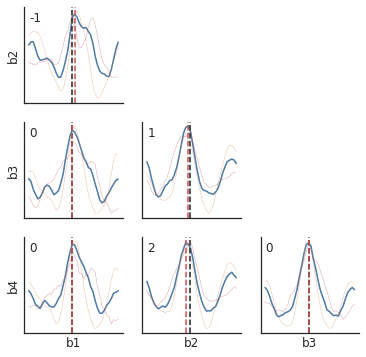

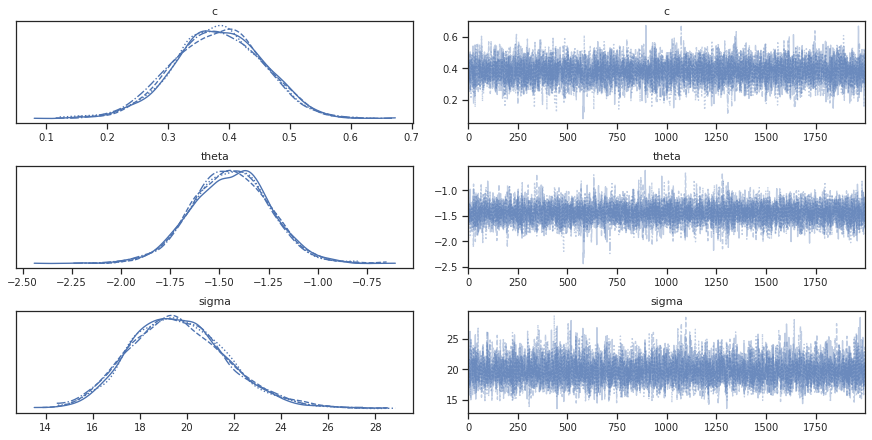

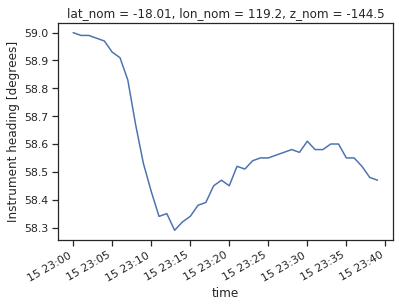

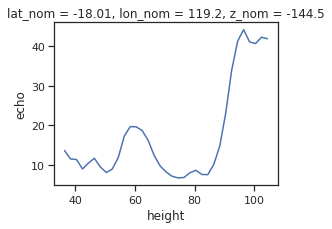

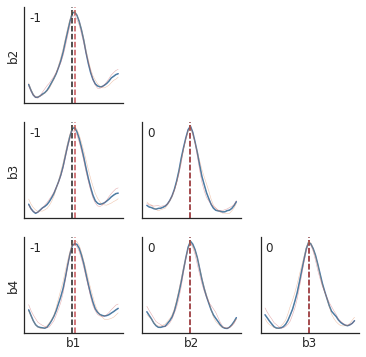

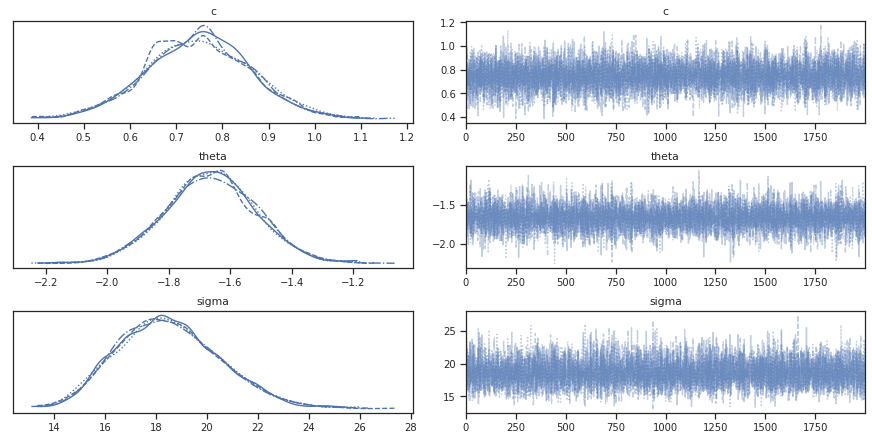

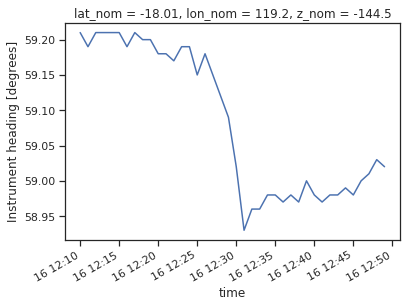

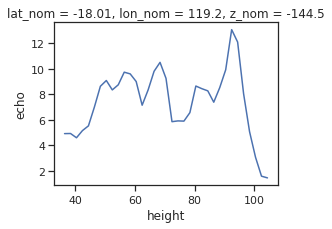

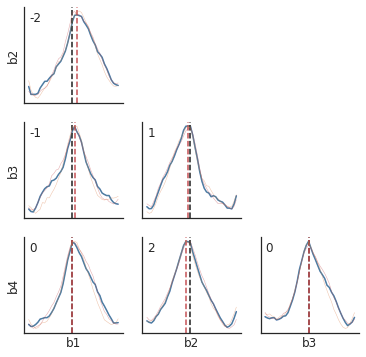

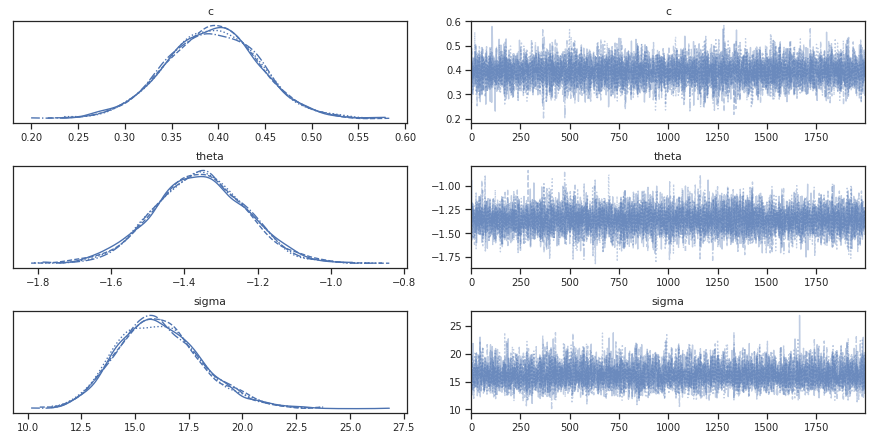

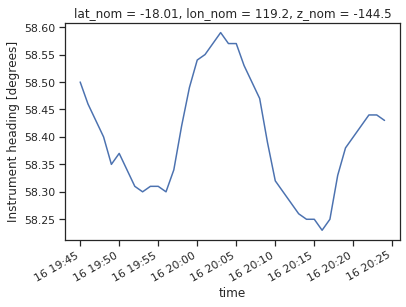

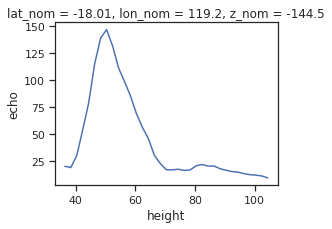

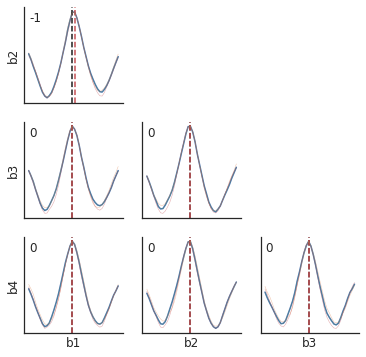

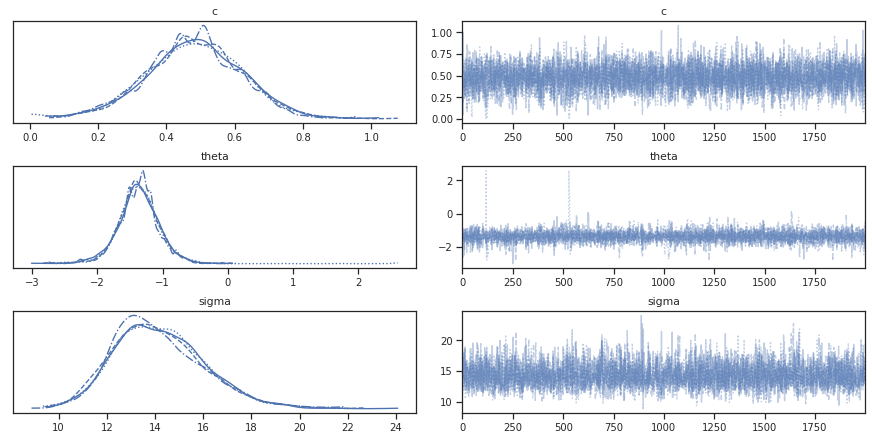

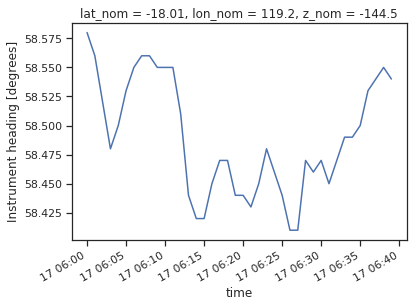

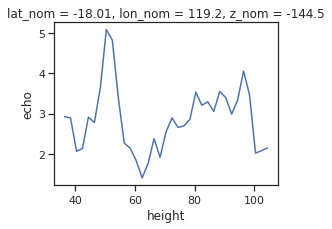

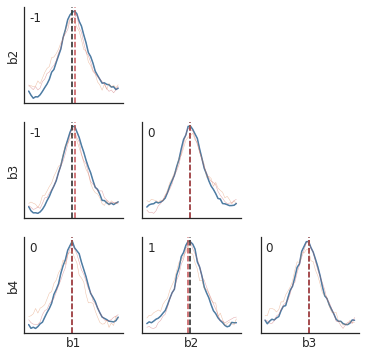

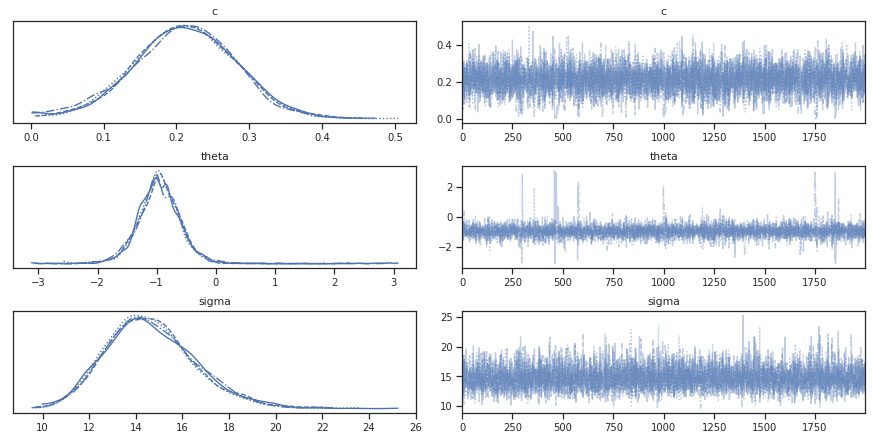

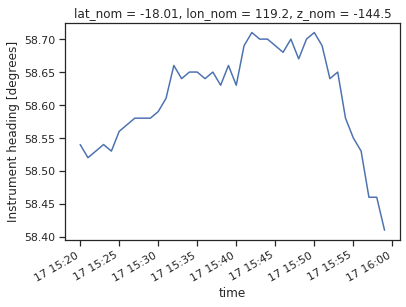

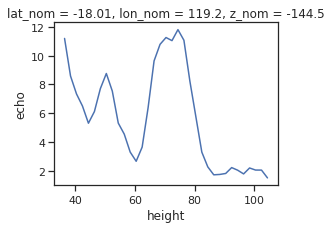

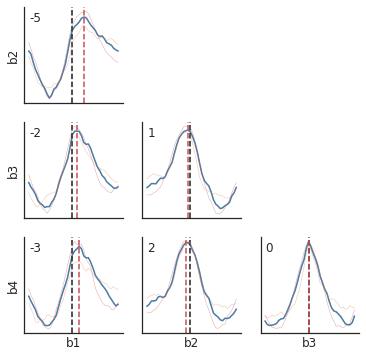

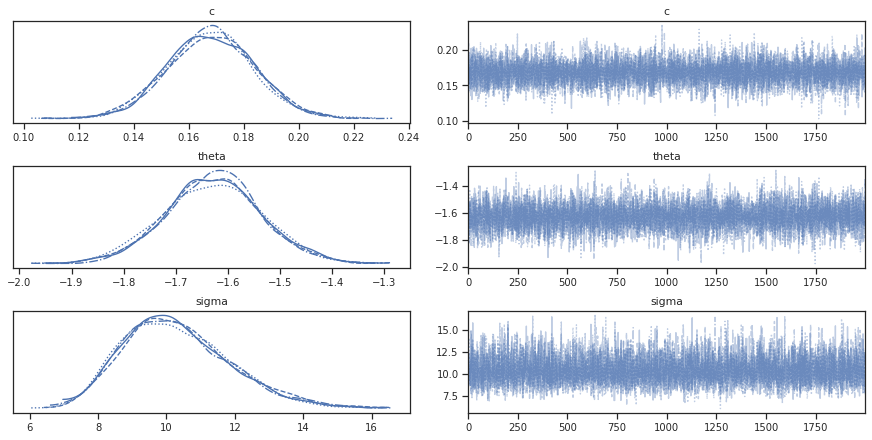

In [32]:
sol_files = glob.glob(os.path.join(save_dir, 'NLIW_*_ADCP.nc'))

# Files need natural sorting!!!
sol_files = natsort.natsorted(sol_files)

fig_sum, ax_sum = plot_polar_dirs()
col = cm.cm.matter(np.linspace(0.3, 1, len(sol_files)))

lag_window = 20
hslice = (35,105)
# hx = [42,45]  #np.arange(29,32)

# Loop through all events
for iii, (sf, cl) in enumerate(zip(sol_files, col)):
    if iii > -1:

        # if iii==0:
        #     hx = np.arange(28,33)
        # if iii==0:
        #     hx = np.arange(15,20)
        # elif iii==1:
        #     hx = np.arange(29,32)
        # elif iii==6:
        #     hx = [20,24]
        # elif iii==10:
        #     hx = [25,35]
        # else:
        #     hx = np.arange(42,48,2)
        # plhx = int(np.mean(np.arange(len(hx))))

        ds = xr.open_dataset(sf)
        ds.close()
        ds = ds.rename({'distance':'height'})
        
        plt.figure()
        ds['heading'].plot()
        

        # hx = np.arange(len(ds.height.values))
        echo_all = ds['echo'].transpose("time", "height", "beam")

        # Get the peak variance bins
        lag_all, corr_all, xb, yb, zb, phi, plhx, hx = get_lagcorr(echo_all, lag_window, hslice=hslice)
        print(hx)
        if np.all(lag_all[plhx] == 0):
            print('No lags - trying elsewhere')
            lag_all, corr_all, xb, yb, zb, phi, plhx, hx = get_lagcorr(echo_all, lag_window, hslice=(30,45), nbins=5)
            print(hx)
        print(lag_all)

        # Plot the variance
        varfig, varax = plt.subplots(1,1, figsize=(4,3))
        echo_all.sel(height=slice(*hslice)).var(dim='time').mean(dim='beam').plot(ax=varax)

        # echo_std = np.std(detrend(echo_all, axis=0), axis=0)
        # echo_std_maxx = np.argmax(np.mean(echo_std, axis=1))
        # hx = np.arange(echo_std_maxx - 2, echo_std_maxx + 3)

        # if iii==2:
        #     fig, ax = plot_beam_distance(xb[plhx], yb[plhx])

        # Plot the lag correlation
        fig, ax = echo_all.sscda.plot_xcorr(hx[plhx], lag_window, zx_all=hx)
        # saveclose(os.path.join(fig_dir, f"Event_{iii+1}_midlag"), fig)

        dtime = np.diff(echo_all.time.values)[0] / np.timedelta64(1, 's')
        obs_data = np.zeros((6,len(hx)))

        trace = gen_pymc3_model(lag_all, dtime, obs_data, xb, yb)

        ax = az.plot_trace(trace)
        # saveclose(os.path.join(fig_dir, f"Event_{iii+1}_trace"), plt.gcf())

        idata = az.from_pymc3(trace=trace)
        heading_rad = np.deg2rad(ds['heading'].mean().values)
        idata.posterior['theta'] = idata.posterior['theta'] + heading_rad - np.deg2rad(180)

        idata.to_netcdf(os.path.join(save_dir, f"Event_{iii}_trace.nc"))
        print(f"Event {iii} saved successfully")
        add_ellipse(ax_sum, trace, cl, heading_rad - np.deg2rad(180))
        plt.draw()

    else:
        print(f"Event {iii} failed")
        continue

In [ ]:
# saveclose(os.path.join(fig_dir, f"Summary_spddir"), fig_sum)